[View in Colaboratory](https://colab.research.google.com/github/kaitlynmcgoldrick/ai-for-social-good-lab/blob/master/MyFirstMLP.ipynb)

# 0. Setup

### To do



*   Include time elapsed to train each epoch - done
*   Find way to compare the prediction and target - done
*   Import to my own machine using Jupyter ?
*   Upload my own image and see how it performs





### Import and install dependencies

In [5]:
import platform
import io

import matplotlib.pyplot as plt
from google.colab import files
from matplotlib.pyplot import cm 

def install_pytorch():
    os = platform.system()
    if os == "Linux":
        !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
    elif os == "Windows":
        !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-win_amd64.whl 
    !pip3 install torchvision


# Install PyTorch.
install_pytorch()

import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

# 1. Preprocessing

In [0]:
# Import data

training_data = torchvision.datasets.MNIST('processed/training.pt', download=True, train=True, transform = torchvision.transforms.ToTensor())

test_data = torchvision.datasets.MNIST('processed/test.pt', download=True, train=True, transform = torchvision.transforms.ToTensor())

# Batch sizes

train_batch_size = 1000
eval_batch_size = 1000

# Data loader

training_loader = torch.utils.data.DataLoader(training_data, batch_size=train_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=eval_batch_size, shuffle=False)

### Shows how flattening works

In [7]:
dd = list(training_loader)
image_batch = dd[0][0]
image_batch.shape
image_batch = image_batch.view([-1, 28*28])
image_batch.shape

torch.Size([1000, 784])

### Plot an image for better understanding

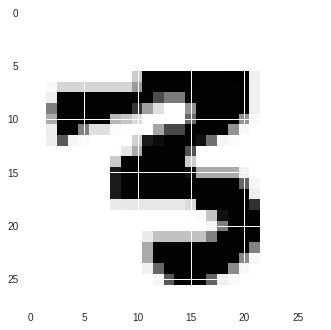

In [8]:
first_image = training_data[54534][0]
first_image.shape

#Necessary to squeeze before plotting
first_image = torch.squeeze(first_image)

plt.imshow(first_image)
plt.show()


# 2. MLP

## My Neural Network

In [0]:
class myNeuralNet(nn.Module):
    def __init__(self):
        super(myNeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 800) # fully connected
        self.fc2 = nn.Linear(800, 600) # fully connected
        self.fc3 = nn.Linear(600, 100) # fully connected
        self.fc4 = nn.Linear(100, 10) # fully connected
        
    def forward(self, x):
        # see the sketch above. 
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
    
        return out
    
my_neural_net = myNeuralNet()

# Turn on eval mode by default
my_neural_net = my_neural_net.eval()


### Show initial prediction matrix

In [10]:
prediction = my_neural_net(image_batch)
prediction[0]

tensor(1.00000e-02 *
       [-9.1066,  0.2002,  0.3513, -3.7047, -8.9668,  3.9845,  1.3294,
        -9.8125, -7.0767, -6.3484])

## Define Cost Function

In [0]:
#@title Default title text
import torch.nn.functional as F


def cost_function(prediction, target):
    loss = F.cross_entropy(prediction, target)
    return loss

## Define Optimizer 

In [0]:
import torch.optim as optim

optimizer = optim.Adam(my_neural_net.parameters(), lr=0.01) 

## Define Training Function

In [0]:
def my_training_func(epoch, model, training_loader, optimizer):

  model.train()
  
  total_loss = 0
  correct = 0
  start_time = time.time()
  for i, (data, target) in enumerate(training_loader):

    # Make te gradients all zero
    optimizer.zero_grad()

    # Flatten the batch 
    data = data.view([-1, 28*28])

    # Evaluate the model 
    predictions = model(data)

    # Compute the loss
    loss = cost_function(predictions, target)

    # Compute the gradients
    loss.backward()

    # Update the parameters
    optimizer.step()

    # Accumulate the loss of each mini batch
    total_loss += loss.data[0]*len(data)

    # Compute the accuracy per minibatch
    pred_classes = predictions.data.max(1, keepdim=True)[1]
    correct += pred_classes.eq(target.data.view_as(pred_classes)).sum().double()
    
  # Compute the mean loss for each epoch
  average_loss = total_loss/len(training_loader.dataset)
  
  # Compute the accuracy for each epoch 
  epoch_accuracy = correct/len(training_loader.dataset)
  
  # Compute time elapsed 
  elapsed_time = (time.time() - start_time)
  
  print("Time Elapsed: {:.2f}s".format(elapsed_time))
  print("Training Epoch: #{}".format(epoch))
  print("Average Loss: {:.5f}".format(average_loss))
  print("Epoch Accuracy: {:.3f}%".format(100.*epoch_accuracy))
  print("\n")
  
  return average_loss, epoch_accuracy

## Define Evaluation Function

In [0]:
def my_eval_func(model, test_loader):
    
    # set the model in .eval() mode 
    model.eval()
    
    total_loss = 0
    correct = 0
    
    # iterate over all the mini-batches 
    for i, (data, target) in enumerate(test_loader):

        # Flatten the batch 
        data = data.view([-1, 28*28])
        
        # Execute the model
        predictions = model(data)
        # Compute the loss
        loss = cost_function(predictions, target) 
        
        # Accumulate the loss of each minibatch
        total_loss += loss.data[0]*len(data)
        
        # Compute the accuracy per minibatch  
        pred_classes = predictions.data.max(1, keepdim=True)[1]

        correct += pred_classes.eq(target.data.view_as(pred_classes)).sum().double()
    
    # Compute the mean loss for each epoch
    average_loss = total_loss/len(test_loader.dataset)
    
    # Compute the accuracy for each epoch
    accuracy = correct/len(test_loader.dataset)
        
    print("Average Loss: {:.5f}".format(average_loss))
    print("Accuracy: {:.3f}%".format(100.*accuracy))
    print("\n")
    
    return average_loss, accuracy

## Checkpointing

In [0]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

  
def load_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'neural_network_{}.pt'.format(epoch)
    
    # load the model parameters 
    model.load_state_dict(torch.load(filename))
    
    
    return model

## Perform Training

In [16]:
# Number of epochs 
#hyperparameter
numEpochs = 5;

# checkpoint frequency 
checkpoint_freq = 10

# path to save the data 
path = './'

# empty lists 
training_losses = []

training_accuracies = []

# Repeat training for each epoch
for epoch in range(1, numEpochs + 1):
    
    # train() function (see above)
    train_loss, train_acc = my_training_func(epoch, my_neural_net, training_loader, optimizer)    
    
    # append lists for plotting and printing 
    training_losses.append(train_loss)    
    
    training_accuracies.append(train_acc)    
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, neural_net, path)

# Last checkpoint
save_model(numEpochs, my_neural_net, path)
    
print("\nOptimization ended.\n")  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Time Elapsed: 11.96s
Training Epoch: #1
Average Loss: 0.55804
Epoch Accuracy: 81.760%


Time Elapsed: 11.69s
Training Epoch: #2
Average Loss: 0.11805
Epoch Accuracy: 96.457%


Time Elapsed: 11.77s
Training Epoch: #3
Average Loss: 0.07843
Epoch Accuracy: 97.537%


Time Elapsed: 11.76s
Training Epoch: #4
Average Loss: 0.05896
Epoch Accuracy: 98.153%


Time Elapsed: 11.79s
Training Epoch: #5
Average Loss: 0.04722
Epoch Accuracy: 98.432%



Optimization ended.



## Evaluate the performance with our Test data

In [0]:
def eval_single(model, single_test_data):
    
    data = single_test_data[0]
    
    # set the model in .eval() mode 
    model.eval()
    
    # Flatten the batch 
    data = data.view([-1, 28*28])
    
    prediction = model(data)
    
    pred_classes = prediction.data.max(1, keepdim=True)[1]
    
    return pred_classes

### Look at prediction vs actual for one data point

In [19]:
dd = list(test_data)
# print(dd[0][0])

first_image = dd[4][0]
first_image = torch.squeeze(first_image)
print(dd[4][1])
plt.imshow(first_image)
plt.show()

test = dd[7005]

prediction = eval_single(my_neural_net, test)
print("Prediction:", prediction)
print("Actual:", test[1])


Prediction: tensor([[ 2]])
Actual: tensor(2)


## Determine Accuracy with Test Data Set

In [20]:
test_loss, test_acc = my_eval_func(my_neural_net, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Average Loss: 0.03585
Accuracy: 98.882%


